# LSTM Stock Predictor Using Closing Prices

In this notebook, a custom LSTM RNN model is built and trained that uses a 3 day window of closing prices of Pharcameutical companies to predict the 4th day closing price. 

Summary of steps:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model


## 1. Data Preparation

In [69]:
# Imports
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path

In [70]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [71]:
# Set the random seed for reproducibility
# Note: This is for the assignment, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [72]:
# Load the closing prices 
file_path = Path('Data/df.csv')
df = pd.read_csv(file_path)
df = df.drop([1])
df.head()

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
0,Symbols,GSK,PFE,AZN,GSK,PFE,AZN
2,1/2/2018,9465500,16185800,6107400,32.10053253,32.92734146,31.99385643
3,1/3/2018,6600800,13456500,4195400,31.97884941,33.1713028,32.05715179
4,1/4/2018,5206400,12378100,3870900,32.03968811,33.24359894,32.1023674
5,1/5/2018,7250700,12492900,3336000,32.60468292,33.30685043,32.43695831


In [73]:
def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close],
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2020-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df

In [74]:
# extract data for GSk and create a dataframe for GSk
gsk_df = construct_df(df, "Volume","Adj Close")
gsk_df.head()

,Volume,Adj Close
Date,,
2020-01-02,2462400.0,45.229774
2020-01-03,2149100.0,44.805626
2020-01-06,2034500.0,44.824902
2020-01-07,1718900.0,44.545349
2020-01-08,1766700.0,44.738148


In [75]:
gsk_df.count()

Volume       186
Adj Close    186
dtype: int64

In [76]:
# extract data for PFE and create a dataframe for PFE
pfe_df = construct_df(df, "Volume.1","Adj Close.1")
pfe_df.head()


,Volume,Adj Close
Date,,
2020-01-02,15668000.0,37.990608
2020-01-03,14158300.0,37.786774
2020-01-06,14963900.0,37.738239
2020-01-07,19077900.0,37.612064
2020-01-08,15563100.0,37.912960


In [77]:
# extract data for AZN and create a dataframe for AZN
azn_df = construct_df(df, "Volume.2","Adj Close.2")
azn_df.head()

,Volume,Adj Close
Date,,
2020-01-02,3587300.0,48.992023
2020-01-03,1208700.0,48.700348
2020-01-06,1992300.0,48.496174
2020-01-07,1871900.0,48.680901
2020-01-08,1869000.0,48.564232


In [78]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Predict closing Prices for PFE using LSTM

In [79]:

# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 1 is the 'Close' column
# Column index 1 is the `Close` column
# feature_column = 1
# target_column = 1
# X, y = window_data(pfe_df, window_size, feature_column, target_column)

In [80]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [81]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


In [82]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.86838794]
  [0.85078361]
  [0.8465919 ]]

 [[0.85078361]
  [0.8465919 ]
  [0.83569471]]

 [[0.8465919 ]
  [0.83569471]
  [0.86168179]]] 

X_test sample values:
[[[0.18103378]
  [0.09827531]
  [0.05000003]]

 [[0.09827531]
  [0.05000003]
  [0.        ]]

 [[0.05000003]
  [0.        ]
  [0.06379344]]]


## Build and Train the LSTM RNN

In this section, custom LSTM RNN is built and fit (trained) using the training data.

1. Define the model architecture
2. Compile the model
3. Fit the model to the training data



In [83]:
# Build the LSTM model. 
# The return sequences need to be set to True when adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [84]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [85]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 30)             3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 30)             7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [86]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2979
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0309
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 8/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 11/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 12/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 13/20
32/32 [==============================

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Note
Apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [87]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.0142


0.014193578623235226

In [88]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [89]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [90]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = pfe_df.index[-len(real_prices): ]) 
stocks.head()


,Real,Predicted
Date,,
2020-07-10,33.136139,34.730156
2020-07-13,33.502560,34.486740
2020-07-14,34.869198,34.361866
2020-07-15,34.889004,34.420177
2020-07-16,35.374264,34.822948


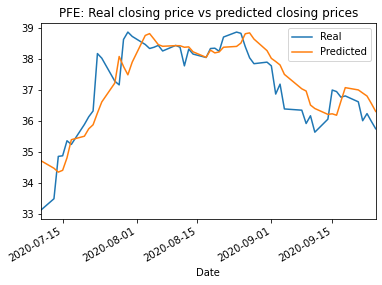

In [91]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 4
stocks.plot(title="PFE: Real closing price vs predicted closing prices")
plt.savefig('./Images/PFE_Closing_predicted_price_.png')

## Predict Closing prices for GSK using LSTM

In [28]:
###GSK###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 1 is the 'Close' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(gsk_df, window_size, feature_column, target_column)

In [29]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [30]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [31]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.9378015 ]
  [0.90958775]
  [0.91086994]]

 [[0.90958775]
  [0.91086994]
  [0.89227451]]

 [[0.91086994]
  [0.89227451]
  [0.9050992 ]]] 

X_test sample values:
[[[0.67140554]
  [0.52050517]
  [0.63564162]]

 [[0.4913946 ]
  [0.61478718]
  [0.54391477]]

 [[0.59140055]
  [0.51781024]
  [0.42670939]]]


In [32]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [33]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [34]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [35]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.3090
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0293
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0276
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 8/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0175
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 11/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 12/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 13/20
32/32 [==============================

In [36]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.0243


0.024341410025954247

In [37]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [38]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [39]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = gsk_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,39.899845,40.049019
2020-07-13,39.445206,39.766769
2020-07-14,39.603340,39.807468
2020-07-15,40.226006,39.503864
2020-07-16,41.461449,39.371189


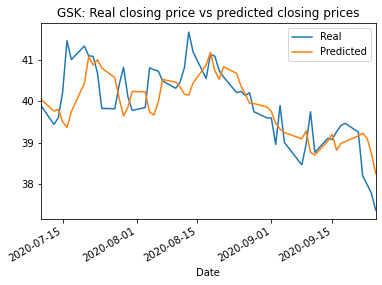

In [40]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="GSK: Real closing price vs predicted closing prices")
plt.savefig('./Images/GSK_Closing_predicted_price_.png')

## Predict Closing prices for AZN using LSTM

In [41]:
###AZN###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 1 is the 'Close' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(azn_df, window_size, feature_column, target_column)

In [42]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [43]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [44]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.66173976]
  [0.64495852]
  [0.63321158]]

 [[0.64495852]
  [0.63321158]
  [0.64383964]]

 [[0.63321158]
  [0.64383964]
  [0.63712723]]] 

X_test sample values:
[[[0.10941442]
  [0.02926165]
  [0.1208644 ]]

 [[0.02926165]
  [0.1208644 ]
  [0.09287518]]

 [[0.1208644 ]
  [0.09287518]
  [0.06615694]]]


In [45]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [46]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [47]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 30)             3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [48]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2615
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 8/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 11/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 12/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 13/20
32/32 [==============================

In [49]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.0372


0.03722156211733818

In [50]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [51]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = azn_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,53.541969,54.674919
2020-07-13,53.333630,54.559345
2020-07-14,52.817760,54.783653
2020-07-15,53.551888,54.616291
2020-07-16,57.540005,54.480782


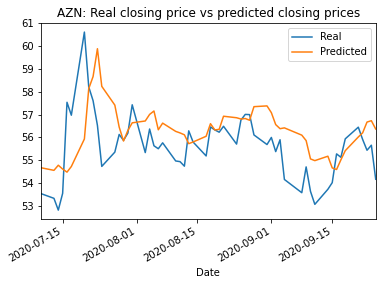

In [53]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="AZN: Real closing price vs predicted closing prices")
plt.savefig('./Images/AZN_Closing_predicted_price_.png')